In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statistics

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import resample
from random import randrange
from random import randint
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [182]:
#adding zeros to class 0 accoridng to distribution in class 1

#splitting test and train into 0 and 1 class
df_train_1 = df_train[df_train['Class'] == 1].copy()
df_train_0 = df_train[df_train['Class'] == 0].copy()
df_test_1 = df_test[df_test['Class'] == 1].copy()
df_test_0 = df_test[df_test['Class'] == 0].copy()

#calculating where zeros start in train class 1
zeros = []

for i in range(len(df_train_1)):
    series = df_train_1.iloc[i]
    for j, element in enumerate(series):
        if element == 0:
            zeros.append(j)
            break

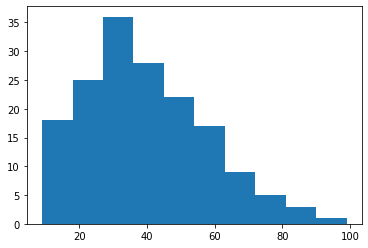

In [184]:
#looking at distribution of zeros
plt.hist(zeros);

In [185]:
#creating approximate distribution of zeros
approx_dist = scipy.stats.kde.gaussian_kde(zeros)

#creating starts from the approximate distribution for train and test
train_0_distrib_as_numpy = approx_dist.resample(len(df_train_0))
train_0_starts = [int(x) for x in train_0_distrib_as_numpy[0]]
test_0_distrib_as_numpy = approx_dist.resample(len(df_test_0))
test_0_starts = [int(x) for x in test_0_distrib_as_numpy[0]]

#putting zeros into train and test class 0 from 
#distribution of zeros in train class 1
for i in range(len(df_train_0)):
    zeros_start = train_0_starts[i]
    for j in range(zeros_start, 101):
        df_train_0.iloc[i, j] = 0
        
for i in range(len(df_test_0)):
    zeros_start = test_0_starts[i]
    for j in range(zeros_start, 101):
        df_test_0.iloc[i, j] = 0
        
#concatenating class 0 and class 1 for train and test
#and reassigning df_test and df_train back
df_train = df_train_0.append(df_train_1)
df_test = df_test_0.append(df_test_1)

In [ ]:
#resampling
def upsample_data(dataframe):
    df_0 = dataframe[dataframe['Class']==0].sample(n=3000)
    df_1 = dataframe[dataframe['Class']==1]

    df_1_up = resample(df_1, replace=True, n_samples=300)

    df = pd.concat([df_0, df_1_up])

    balance = df['Class'].value_counts()
    print(balance)
    return df

df_train = upsample_data(df_train)

x_train = torch.tensor(df_train.iloc[:,1:].values.tolist())
x_test = torch.tensor(df_test.iloc[:,1:].values.tolist())

#adding noise
def add_noise(tensor, std, mean):
    normal = torch.normal(mean, std, size=(len(x_train), 100))
    output = tensor + normal
    return output

x_train = add_noise(x_train, 0.05, 0)

y_train = torch.tensor(df_train['Class'].values, dtype=torch.long)
y_test = torch.tensor(df_test['Class'].values, dtype=torch.long)

x_train = x_train.view(-1, 1, 100)
x_test = x_test.view(-1, 1, 100)

x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

train_len = int(len(x_train))
test_len = int(len(x_test))

In [ ]:
#displaying random instances
def display(dataframe):
    rand = randrange(len(dataframe)-1)
    data = dataframe.iloc[rand,1:101]
    category = dataframe.iloc[rand, 0].astype(int)
    title = "Class: " + category.astype(str)
    plt.plot(data[::-1])
    plt.title(title)
    plt.axis('off')
    plt.show()

display(df_train)

In [212]:
EPOCHS = 20
BATCH_SIZE = 100
CHUNK = 1000
LR = 0.001
VALIDATE = True

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.maxpool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.maxpool2 = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*16, 64*4)
        self.fc2 = nn.Linear(64*4, 64)
        self.fc3 = nn.Linear(64, 2)      

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.batchnorm1(x)
        x = self. maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self. maxpool2(x)
        x = x.view(-1, 64*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

net.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

def acc_func(out, labels):
    _, predicted = torch.max(out, 1)
    total = len(labels)
    correct = (predicted == labels).sum().item()
    accuracy = correct/total
    return accuracy

def prec_func(outputs, labels):
    out = torch.max(outputs, 1)[1]
    tp = (out * labels == 1).sum(dim=0).item()
    fp = (out == 1).sum(dim=0).item() - tp
    tn = ((out + labels) == 0).sum(dim=0).item()
    fn = (out == 0).sum(dim=0).item() - tn
    if (tp + fp) == 0:
        return 'undefined'
    else:
        return tp / (tp + fp)

def rec_func(outputs, labels):
    out = torch.max(outputs, 1)[1]
    tp = (out * labels == 1).sum(dim=0).item()
    fp = (out == 1).sum(dim=0).item() - tp
    tn = ((out + labels) == 0).sum(dim=0).item()
    fn = (out == 0).sum(dim=0).item() - tn
    if (tp + fn) == 0:
        return 'undefined'
    else:
        return tp / (tp + fn)

def bacc_func(outputs, labels):
    out = torch.max(outputs, 1)[1]
    tp = (out * labels == 1).sum(dim=0).item()
    fp = (out == 1).sum(dim=0).item() - tp
    tn = ((out + labels) == 0).sum(dim=0).item()
    fn = (out == 0).sum(dim=0).item() - tn 
    if ((tp + fn) == 0) or ((tn + fp) == 0):
        return 'undefined'
    else:
        return (tp / (tp + fn) + tn / (tn + fp)) / 2 

def validation():
    val_accs = []
    val_loss = []
    val_precs = []
    val_recs = []
    val_baccs = []
    for i in range(0, test_len, BATCH_SIZE):
        x_batch = x_test[i:i+BATCH_SIZE]
        y_batch = y_test[i:i+BATCH_SIZE]
        with torch.no_grad():
                outputs = net(x_batch)
        _val_loss = loss_func(outputs, y_batch)
        val_loss.append(_val_loss.item())
        val_acc = acc_func(outputs, y_batch)
        val_accs.append(val_acc)
        val_prec = prec_func(outputs, y_batch)
        val_precs.append(val_prec)
        val_rec = rec_func(outputs, y_batch)
        val_recs.append(val_rec)
        val_bacc = bacc_func(outputs, y_batch)
        val_baccs.append(val_bacc)
    
    val_acc = np.array([x for x in val_accs if type(x) != str]).mean()
    val_loss = statistics.mean(val_loss)
    val_prec = np.array([x for x in val_precs if type(x) != str]).mean()
    val_rec = np.array([x for x in val_recs if type(x) != str]).mean()
    val_bacc = np.array([x for x in val_baccs if type(x) != str]).mean()
    
    return val_acc, val_loss, val_prec, val_rec, val_bacc


training_loss = []
training_acc = []
training_prec = []
training_rec = []
training_bacc = []

validation_loss = []
validation_acc = []
validation_prec = []
validation_rec = []
validation_bacc = []

def train():

    for epoch in range(EPOCHS):

        print('EPOCH_______________________________', epoch+1)

        loss = []
        accs = []
        precs = []
        recs = []
        baccs = []

        for i in range(0, train_len, BATCH_SIZE):

            x_batch = x_train[i:i+BATCH_SIZE]
            y_batch = y_train[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(x_batch)
            _loss = loss_func(outputs, y_batch)
            loss.append(_loss.item())

            _loss.backward()
            optimizer.step()
            
            acc = acc_func(outputs, y_batch)
            accs.append(acc)
            
            prec = prec_func(outputs, y_batch)
            precs.append(prec)
            
            rec = rec_func(outputs, y_batch)
            recs.append(rec)
            
            bacc = bacc_func(outputs, y_batch)
            baccs.append(bacc)

            if VALIDATE:
                val_acc, val_loss, val_prec, val_rec, val_bacc = validation()
            else:
                val_acc, val_loss, val_prec, val_rec, val_bacc = 0, 0, 0, 0, 0

            if i % CHUNK == 0:
                accuracy = np.array([x for x in accs if type(x) != str]).mean()
                loss = statistics.mean(loss)
                precision = np.array([x for x in precs if type(x) != str]).mean()
                recall = np.array([x for x in recs if type(x) != str]).mean()
                balanced_accuracy = np.array([x for x in baccs if type(x) != str]).mean()

                training_loss.append(loss)
                training_acc.append(accuracy)
                training_prec.append(precision)
                training_rec.append(recall)
                training_bacc.append(balanced_accuracy)
                
                validation_loss.append(val_loss)
                validation_acc.append(val_acc)
                validation_prec.append(val_prec)
                validation_rec.append(val_rec)
                validation_bacc.append(val_bacc)

                print('[', i, '/', train_len, ']',
                    'Loss: ', round(float(loss), 3),
                    'Accuracy: ', round(float(accuracy), 3),
                    'Precision: ', round(float(precision), 3), 
                    'Recall: ', round(float(recall), 3), 
                    'Balanced Accuracy:', round(float(balanced_accuracy), 3),
                    'Val Loss: ', round(float(val_loss), 3),
                    'Val Accuracy: ', round(float(val_acc), 3),
                    'Val Precision: ', round(float(val_prec), 3),
                    'Val Recall: ', round(float(val_rec), 3),
                    'Val Balanced Accuracy: ', round(float(val_bacc), 3),)
                loss = []
                accs = []
                precs = []
                recs = []
                baccs = []

    print('Finished training!')

train()

EPOCH_______________________________ 1
[ 0 / 3300 ] Loss:  0.677 Accuracy:  0.67 Precision:  0.139 Recall:  0.714 Balanced Accuracy: 0.69 Val Loss:  0.403 Val Accuracy:  0.98 Val Precision:  nan Val Recall:  0.0 Val Balanced Accuracy:  0.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.


[ 1000 / 3300 ] Loss:  0.311 Accuracy:  0.905 Precision:  1.0 Recall:  0.017 Balanced Accuracy: 0.508 Val Loss:  0.116 Val Accuracy:  0.98 Val Precision:  0.567 Val Recall:  0.55 Val Balanced Accuracy:  0.772
[ 2000 / 3300 ] Loss:  0.105 Accuracy:  0.954 Precision:  0.906 Recall:  0.646 Balanced Accuracy: 0.819 Val Loss:  0.071 Val Accuracy:  0.957 Val Precision:  0.339 Val Recall:  0.9 Val Balanced Accuracy:  0.934
[ 3000 / 3300 ] Loss:  0.047 Accuracy:  0.979 Precision:  0.878 Recall:  0.885 Balanced Accuracy: 0.937 Val Loss:  0.156 Val Accuracy:  0.925 Val Precision:  0.225 Val Recall:  1.0 Val Balanced Accuracy:  0.966
EPOCH_______________________________ 2
[ 0 / 3300 ] Loss:  0.055 Accuracy:  0.97 Precision:  0.7 Recall:  1.0 Balanced Accuracy: 0.984 Val Loss:  0.109 Val Accuracy:  0.948 Val Precision:  0.301 Val Recall:  0.9 Val Balanced Accuracy:  0.93
[ 1000 / 3300 ] Loss:  0.051 Accuracy:  0.977 Precision:  0.88 Recall:  0.897 Balanced Accuracy: 0.942 Val Loss:  0.145 Val Accu

[ 3000 / 3300 ] Loss:  0.021 Accuracy:  0.991 Precision:  0.938 Recall:  0.964 Balanced Accuracy: 0.979 Val Loss:  0.08 Val Accuracy:  0.972 Val Precision:  0.429 Val Recall:  0.9 Val Balanced Accuracy:  0.941
EPOCH_______________________________ 11
[ 0 / 3300 ] Loss:  0.007 Accuracy:  1.0 Precision:  1.0 Recall:  1.0 Balanced Accuracy: 1.0 Val Loss:  0.074 Val Accuracy:  0.977 Val Precision:  0.429 Val Recall:  0.9 Val Balanced Accuracy:  0.941
[ 1000 / 3300 ] Loss:  0.023 Accuracy:  0.988 Precision:  0.955 Recall:  0.918 Balanced Accuracy: 0.957 Val Loss:  0.091 Val Accuracy:  0.967 Val Precision:  0.387 Val Recall:  0.9 Val Balanced Accuracy:  0.939
[ 2000 / 3300 ] Loss:  0.026 Accuracy:  0.988 Precision:  0.893 Recall:  0.985 Balanced Accuracy: 0.987 Val Loss:  0.066 Val Accuracy:  0.98 Val Precision:  0.467 Val Recall:  0.9 Val Balanced Accuracy:  0.943
[ 3000 / 3300 ] Loss:  0.023 Accuracy:  0.99 Precision:  0.975 Recall:  0.913 Balanced Accuracy: 0.955 Val Loss:  0.098 Val Accur

[ 1000 / 3300 ] Loss:  0.014 Accuracy:  0.994 Precision:  0.966 Recall:  0.965 Balanced Accuracy: 0.981 Val Loss:  0.111 Val Accuracy:  0.973 Val Precision:  0.442 Val Recall:  0.9 Val Balanced Accuracy:  0.941
[ 2000 / 3300 ] Loss:  0.018 Accuracy:  0.993 Precision:  0.946 Recall:  0.971 Balanced Accuracy: 0.983 Val Loss:  0.074 Val Accuracy:  0.983 Val Precision:  0.486 Val Recall:  0.9 Val Balanced Accuracy:  0.943
[ 3000 / 3300 ] Loss:  0.025 Accuracy:  0.991 Precision:  0.968 Recall:  0.941 Balanced Accuracy: 0.969 Val Loss:  0.105 Val Accuracy:  0.98 Val Precision:  0.484 Val Recall:  0.9 Val Balanced Accuracy:  0.943
Finished training!


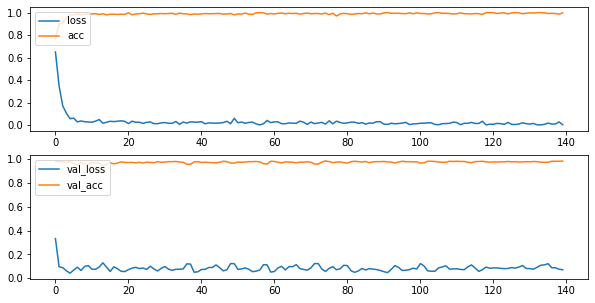

In [210]:
#learning curves
def learning_curves(loss, acc, val_loss, val_acc):
    fig, ax = plt.subplots(2, figsize=(10, 5))
    ax[0].plot(loss, label="loss")
    ax[0].plot(acc, label="acc")
    ax[0].legend(loc=2)
    ax[1].plot(val_loss, label="val_loss")
    ax[1].plot(val_acc, label="val_acc")
    ax[1].legend(loc=2)
    plt.show()

learning_curves(training_loss, training_acc, validation_loss, validation_acc)

In [ ]:
#checking result
results = torch.max(net(x_test), 1)[1]

for i, result in enumerate(results):
    df_for_plotting = df_test.iloc[i].copy()
    true_class = int(df_for_plotting[0])
    predicted_class = result.item()
    if predicted_class == 1:
        plt.plot(df_for_plotting[::-1])
        plt.title('true class: ' + str(true_class) + '   ' + 'predicted class: ' + str(predicted_class))
        plt.axis('off')
        plt.show();